# Suppert Vector Machines and Kernels

In this exercise, we will 
* implement the [SMO algorithm](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf) for training the SVM dual,
* implement the Gaussian kernel,
* operate with it on low and high dimensional data and
* construct a kernel from a feature map for a specific problem

In [1]:
%load_ext autoreload
%autoreload 2
import utils
import implementation
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

**Exercise**: Implement the SMO algorithm in the stubs in *implementation.py*. Use the pseudo-code that is provided in the course material.

**Exercise**: Implement the Gaussian kernel function that is defined as

$$ k(\boldsymbol{x}, \boldsymbol{z}) = \exp\left(-\frac{\|\boldsymbol{x}-\boldsymbol{z}\|^2}{2\sigma^2}\right). $$

in your *implementation.py*. You can use the function `utils.pairwise_distance`. For two data matrices $X\in\mathbb{R}^{m\times d}$ and $Z\in\mathbb{R}^{n\times d}$ the function call `pairwise_distance(X, Z)` returns the distance matrix $D\in\mathbb{R}^{m\times n}$ with $D_{ij} = \|\boldsymbol{x}_i - \boldsymbol{z}_j\|^2$.

We are now equipped with an SVM training algorithm as well as a nonlinear kernel (the linear kernel is also given in `utils.linear_kernel`). Firstly, we apply it to some two-dimensional data set.

## A Two-Dimensional Example

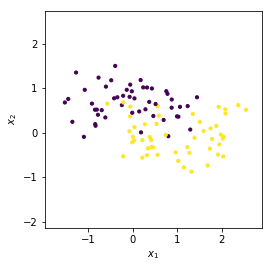

In [3]:
n_train, n_test = 100, 100
Xtrain, ytrain, Xtest, ytest = utils.get_2d_data(n_train, n_test)
utils.plot_2d(Xtrain, ytrain)

For the Gaussian kernel, one has to choose a bandwidth parameter $\sigma$. Here, we use a [simple heuristic from Alex Smola](https://blog.smola.org/post/940859888/easy-kernel-width-choice), where we pick $2\sigma^2$ as some quantile $q\in(0,1)$ of pairwise distances. Before training, we can visualize the kernel matrix and also the eigenvalue spectrum. In principal, we want quick decay of eigenvalues. The heuristic of Smola's guarantees this to happen.

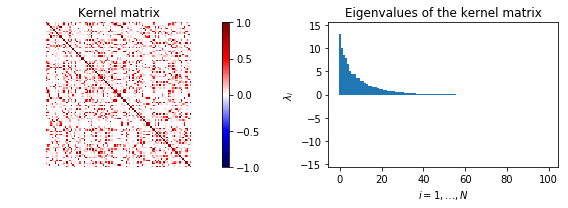

In [4]:
sigma = utils.select_bandwidth(Xtrain, q=.1)
utils.plot_kernel(implementation.gaussian_kernel(Xtrain, Xtrain, sigma))

**Exercise:** Train the SVM on the two-dimensional data set. 
* Try a linear kernel `kernel='linear'` and a Gaussian kernel `kernel='gaussian'`. What is the difference?
* Try different values for $\sigma$ by choosing different quantiles $q$ in `select_bandwidth`. How does it impact the solution in terms of training and test errors and number of support vectors?
* Change the regularization coefficient $C$. Do you observe a difference in training time?

Number of training samples : 100
Number of support vectors  : 33
Number of parameters       : 132
Fraction of training errors: 0.00
Fraction of test errors    : 0.21


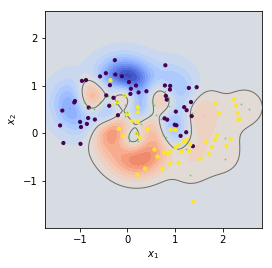

In [5]:
svm = implementation.svm(kernel='gaussian', sigma=sigma, C=100000000) # the higer the C 
#the smaller the margin because I penalize a lot for wrongly classified point (paper eq.8)
svm.fit(Xtrain, ytrain)
print("Fraction of training errors: %.2f"%(((ytrain != svm.predict(Xtrain))).sum()/len(ytrain)))
print("Fraction of test errors    : %.2f"%(((ytest != svm.predict(Xtest))).sum()/len(ytest)))

utils.plot_2d(Xtest, ytest, svm)

## A High-Dimensional Example

The PatternNet data set contains images of size $256\times 256$, separated into 38 classes with 800 images per class.

**Exercise**:
- *Load* two different classes from the PatternNet data set, using the function `utils.get_image_data` and *visualize* some examples.
- *Train* the SVM. Which kernel (Gaussian or linear) works better? What does it tell you about the data?

If the dimensionality is high, the kernel matrix takes a long time to be computed (although we have only 1600 samples). In particular, the calculation of pairwise distances becomes computational expensive. It can easily take longer than the actual training.

*Hint:* The function `utils.pairwise_distance` takes an additional argument `device` that can take a pytorch device descriptor.

In [6]:
n_train, n_test = 200, 600
classes = ['sparse_residential', 'dense_residential']
Xtrain, ytrain, Xtest, ytest = utils.get_image_data(n_train, n_test, classes)

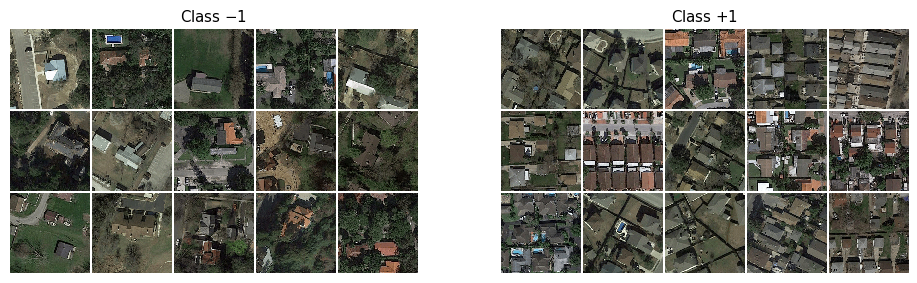

In [7]:
plt.figure(figsize=(10,3), dpi=90)
plt.subplot(121)
plt.title(r'Class $-1$')
utils.images(Xtrain[ytrain==-1][:15], 3, 5)
plt.subplot(122)
plt.title(r'Class $+1$')
utils.images(Xtrain[ytrain==1][:15], 3, 5)
plt.show()

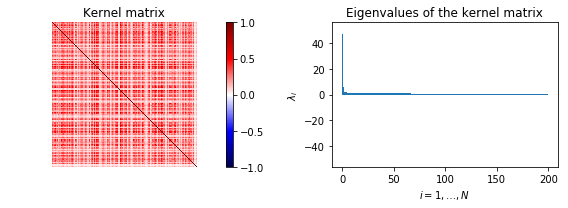

Number of training samples : 200
Number of support vectors  : 164
Number of parameters       : 32244040
Fraction of training errors: 0.04
Fraction of test errors    : 0.17


In [8]:
### YOUR CODE HERE ###
# import torch as tr
# device = tr.device('cuda')
device = None
sigma = utils.select_bandwidth(Xtrain, .1, device=device)
svm = implementation.svm(kernel='gaussian', sigma=sigma, C=1, device=device)
utils.plot_kernel(svm.kernel(Xtrain, Xtrain))
svm.fit(Xtrain, ytrain)
print("Fraction of training errors: %.2f"%(((ytrain != svm.predict(Xtrain))).sum()/n_train))
print("Fraction of test errors    : %.2f"%(((ytest != svm.predict(Xtest))).sum()/n_test))

The dimensionality can often be reduced linearly with PCA and the kernel be applied to the low-dimensional data. Usually, the classification performance does not drop strongly, but runtime performance will be drastically improved. Use the code block below to reduce the image dimensions, if you encounter long runtime.

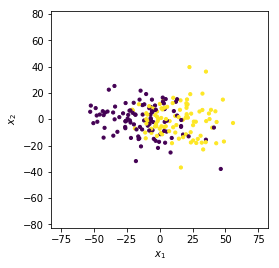

In [9]:
Xtrain, Xtest = utils.PCA(Xtrain, Xtest, n_components=5)
utils.plot_2d(Xtrain, ytrain)

## Limitations of shallow learning

Some functions are particularly difficult to learn for kernel machines with the Gaussian kernel. When labels can not be inferred from the training examples that are nearby in the Euclidean sense, the Gaussian kernel will fail. In this exencise, we encounter such example.

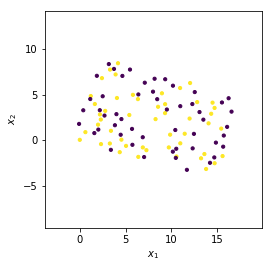

In [10]:
Xtrain, ytrain, Xtest, ytest = utils.get_2d_structured(n_train=100, n_test=50)
utils.plot_2d(Xtrain, ytrain)

**Exercise**: Train a SVM on the 2D data set above with the Gaussian kernel. Try to find good parameters. What do you observe regarding the number of support vectors compared to the number of training samples?

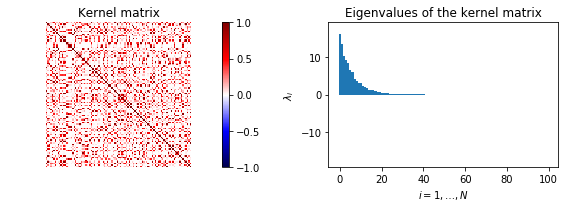

Number of training samples : 100
Number of support vectors  : 99
Number of parameters       : 396
Fraction of training errors: 0.40
Fraction of test errors    : 0.60


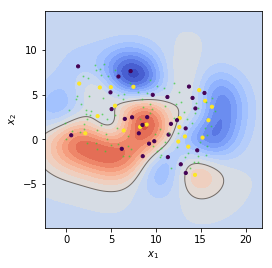

In [42]:
sigma = utils.select_bandwidth(Xtrain, .15)
utils.plot_kernel(implementation.gaussian_kernel(Xtrain, Xtrain, sigma))

svm = implementation.svm(kernel='gaussian', sigma=sigma, C=0.7)
svm.fit(Xtrain, ytrain)
print("Fraction of training errors: %.2f"%(((ytrain != svm.predict(Xtrain))).sum()/len(ytrain)))
print("Fraction of test errors    : %.2f"%(((ytest != svm.predict(Xtest))).sum()/len(ytest)))
utils.plot_2d(Xtest, ytest, svm)

**Exercise**: Develop a *feature map* $\Phi\colon\mathcal X\rightarrow\mathcal F$ that is suited for this particular problem. 
The feature map computes the following features:

$$\Phi(X) = \cos(\pi \cdot X\mathbf W + \boldsymbol b)$$

with $\mathbf W = \left[\begin{array}{rr}1.3 & -0.5\\1.3 & 1.7\end{array}\right]$ and $\boldsymbol b = \left[\begin{array}{r}0 \\ 1\end{array}\right]$. That is a linear map followed by a nonlinearity.

* Project the data in the feature space $\mathcal F$: $Z \gets \Phi(X)$.
* Visualize the new features and train a linear SVM on the new features.

Number of training samples : 100
Number of support vectors  : 7
Number of parameters       : 28


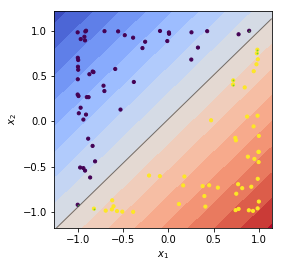

In [35]:
def Phi(X):
    ### YOUR CODE HERE ###
    W = np.array([[1.3,-0.5], [1.3, 1.7]])
    b = np.array([[0,1]])
    Z = X.dot(W) + b
    return np.cos (np.pi*Z)

Ztrain = Phi(Xtrain)
Ztest  = Phi(Xtest)


svm_lin = implementation.svm(kernel='linear', C=30)
svm_lin.fit(Ztrain, ytrain)
utils.plot_2d(Ztrain, ytrain, svm_lin)

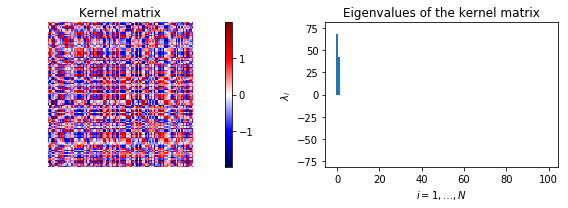

Number of training samples : 100
Number of support vectors  : 7
Number of parameters       : 28
Fraction of training errors: 0.00
Fraction of test errors    : 0.00


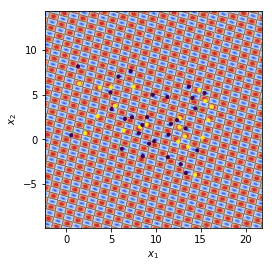

In [43]:
def kernel(x, y):
    return np.dot(Phi(x), Phi(y).T)
utils.plot_kernel(kernel(Xtrain, Xtrain))

svm = implementation.svm(kernel=kernel, C=1000)
svm.fit(Xtrain, ytrain)
print("Fraction of training errors: %.2f"%(((ytrain != svm.predict(Xtrain))).sum()/len(ytrain)))
print("Fraction of test errors    : %.2f"%(((ytest != svm.predict(Xtest))).sum()/len(ytest)))
utils.plot_2d(Xtest, ytest, svm)